In [1]:
#! If you want to force use of CPU (before import of tensorflow)
import os
# os.environ['CUDA_VISIBLE_DEVICES']='-1'
# os.environ['OMP_NUM_THREADS'] = '4'
# os.environ['export OPENBLAS_NUM_THREADS']='4'

#! import as tf
import tensorflow as tf

#! If you want to limit number of threads, the mechine has 32 virtual cores (16 physical ones)
print('thread inter = ', tf.config.threading.get_inter_op_parallelism_threads() )
print('thread intra = ', tf.config.threading.get_intra_op_parallelism_threads() )
 
tf.config.threading.set_inter_op_parallelism_threads(4)
tf.config.threading.set_intra_op_parallelism_threads(4)

#! If you want to limit the GPU memory usage, the machine has ~24GB. For most applications a few GBs is enough.
#! If you max out what you specify progressively up the threshhold.
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.set_logical_device_configuration(
    physical_devices[0],
    [tf.config.LogicalDeviceConfiguration(memory_limit=20_000)])

  logical_devices = tf.config.list_logical_devices('GPU')

except:
  # Invalid device or cannot modify logical devices once initialized.
  pass

#! Will print out what devices you are using
tf.config.list_physical_devices()



import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

from mlkernels.tensorflow import Matern32, EQ, Matern12, Matern52


from LFM.NeuralNet import NeuralN
from LFM.utilities import pshape
from LFM.utilities import reparameterize, log_normal_pdf, expHighLowFunc_01, exp_start_end_x_func
from LFM.GICNet    import FFLayer, KIPLayer, GICNet

pi  = tf.constant(np.pi, tf.float32)
tfd = tfp.distributions
tfb = tfp.bijectors


dirname='data-lfmDiag-nslid-smallColLonTrain/'
os.makedirs(dirname, exist_ok=True)



2023-01-02 05:16:39.624770: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-02 05:16:39.708080: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-02 05:16:40.070888: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-02 05:16:40.070920: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

thread inter =  0
thread intra =  0


2023-01-02 05:16:40.668184: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-02 05:16:40.668307: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-02 05:16:40.669240: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-02 05:16:40.669429: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [2]:
dimU = 3
dimZ = 2
dimW = 1
dimX = 3
                         #  x         y         t
domain     = tf.constant( [[0., 1.], [0., 1.], [0., 1.]] )

nxSamples  = 512
# 9^3

# currently in dataset                rho,  mu                                  rho, mu  
# zDist = tfd.Uniform(low=tf.constant([0.5, 0.1], shape=[dimZ]), high=tf.constant([1., 1.], shape=[dimZ]))
# wDist = tfd.Uniform(low=tf.constant([0.5], shape=[dimW]), high=tf.constant([1.], shape=[dimW]))

# zDist = tfd.Uniform(low=tf.constant([1., 0.1], shape=[dimZ]), high=tf.constant([1., 0.1], shape=[dimZ]))
# wDist = tfd.Uniform(low=tf.constant([1.], shape=[dimW]), high=tf.constant([1.], shape=[dimW]))

# currently in dataset                rho,  mu                                  rho, mu  
zDist = tfd.Uniform(low=tf.constant([0.8, 0.1], shape=[dimZ]), high=tf.constant([1., 1.], shape=[dimZ]))
wDist = tfd.Uniform(low=tf.constant([1.], shape=[dimW]), high=tf.constant([1.], shape=[dimW]))

e_bound = 0.

def raveled3DDomainGrid(resolution):
    x, y, t       = tf.linspace(domain[0][0], domain[0][1], resolution[0]), tf.linspace(domain[1][0], domain[1][1], resolution[1]), \
                    tf.linspace(domain[2][0], domain[2][1], resolution[2])
    X, Y, T       = np.meshgrid(x, y, t, indexing='ij')
    Xr, Yr, Tr    = tf.reshape(tf.constant(X, dtype=tf.float32), [-1,1]), tf.reshape(tf.constant(Y, dtype=tf.float32), [-1,1]),\
                    tf.reshape(tf.constant(T, dtype=tf.float32), [-1,1])
    XYTr          = tf.concat([Xr, Yr, Tr], 1)
    return XYTr

def sampleDomain(n):
    xrand = tf.random.uniform(minval=domain[0][0]+e_bound, maxval=domain[0][1]-e_bound, shape=[n, 1])
    yrand = tf.random.uniform(minval=domain[1][0]+e_bound, maxval=domain[1][1]-e_bound, shape=[n, 1])
    trand = tf.random.uniform(minval=domain[2][0]+e_bound, maxval=domain[2][1], shape=[n, 1])
    return tf.concat([xrand, yrand, trand], 1)

print('samples.shape', sampleDomain(10))

b      = zDist.sample()
xtvect = sampleDomain(nxSamples)
    
    

samples.shape tf.Tensor(
[[0.6135398  0.0608052  0.51573455]
 [0.8313172  0.3693912  0.37764835]
 [0.9988878  0.06921577 0.93497026]
 [0.34402382 0.35631275 0.61224854]
 [0.86067164 0.48754835 0.60400856]
 [0.27199614 0.07077467 0.38339412]
 [0.56541085 0.03277385 0.40904713]
 [0.7064885  0.04236972 0.19575703]
 [0.98426795 0.5601833  0.47714555]
 [0.21850967 0.8467028  0.38975143]], shape=(10, 3), dtype=float32)


In [3]:
# Define alpha network

dim_DeepO_out  = dimU * 2

alphaNet  = NeuralN('alpha', np.array([ 1, 1, dimZ]) )

# numFreq = 100
# nhAlpha = 500

numFreq = 100
nhAlpha = 200

activ_alpha = 'swish'
# activ_alpha = tf.sin

alphaNet.NN = tf.keras.Sequential([ 
                                tf.keras.layers.Dense( nhAlpha, input_dim=( numFreq * 2 + dimZ + dimW ), activation=activ_alpha),
                                # tf.keras.layers.Dense( nhAlpha, input_dim=( dimX + dimZ + dimW ), activation=activ_alpha),
                                tf.keras.layers.Dense( nhAlpha, activation=activ_alpha),
                                tf.keras.layers.Dense( nhAlpha, activation=activ_alpha),
                                tf.keras.layers.Dense( nhAlpha, activation=activ_alpha),
                                tf.keras.layers.Dense( nhAlpha, activation=activ_alpha),
                                tf.keras.layers.Dense( nhAlpha, activation=activ_alpha),
                                tf.keras.layers.Dense( nhAlpha, activation=activ_alpha),
                                tf.keras.layers.Dense( nhAlpha, activation=activ_alpha),
                                tf.keras.layers.Dense( nhAlpha, activation=activ_alpha),
                                tf.keras.layers.Dense( nhAlpha, activation=activ_alpha),
                                tf.keras.layers.Dense( nhAlpha, activation=activ_alpha),
#                                 tf.keras.layers.Dense( nhAlpha, activation=activ_alpha),
#                                 tf.keras.layers.Dense( nhAlpha, activation=activ_alpha),
                                tf.keras.layers.Dense( dim_DeepO_out ) ])

freqsX = tf.linspace(0., 1., numFreq)

freqs_x  = expHighLowFunc_01(1., 0.01, freqsX)[None,:]
freqs_y  = expHighLowFunc_01(1., 0.01, freqsX)[None,:]
freqs_t  = expHighLowFunc_01(1., 0.01, freqsX)[None,:]
freqs    = tf.concat([freqs_x, freqs_y, freqs_t], 1)
# tf.print('all freqs FFN \n', freqs, summarize=-1) 
#now they are trainable
alphaNet.fLayer = [ FFLayer( freqs, trainable=True ) ]

alphaNet.lower_alpha = tf.constant(1e-4)
alphaNet.upper_w     = tf.constant(1.)

def alphaMap(self, z, w, x):

        z_tile  = tf.tile(tf.reshape(z, [1,-1]), [x.shape[0], 1])
        w_tile  = tf.tile(tf.reshape(w, [1,-1]), [x.shape[0], 1])
        print('x.shape', x.shape)
        # print('xFreq.shape', xFreq.shape)
        # x       = tf.reshape(x, [-1,dimX])

        # x_input = tf.concat([x, z_tile, w_tile], 1)

        xFreq   = self.fLayer[0]( x )
        x_input = tf.concat([xFreq, z_tile, w_tile], 1)

        print('x_input.shape', x_input.shape)
        mapped  = self.NN( x_input )
        
        mean, logvar = mapped[:,:dimU], mapped[:,dimU:2*dimU]
        
        tf.debugging.assert_all_finite(mean, 'mean not finite')
        tf.debugging.assert_all_finite(logvar, 'logvar not finite')

        logvar = self.dBoundwalpha_log( logvar )

        print('alpha mean.shape = ',   mean.shape)
        print('alpha logvar.shape = ', logvar.shape)

        return mean, logvar

from types import MethodType
alphaNet.call = MethodType(alphaMap, alphaNet)
alphaNet(tf.constant(1., shape=[dimZ]), tf.constant(1., shape=[dimW]), sampleDomain(30))
alphaNet.compile()
alphaNet.NN.summary()
alphaNet.summary()

# alphaNet.save_weights(dirname + '/alphaModel/alphaModel-lfmDiag')
# alphaNet.load_weights(dirname + '/alphaModel/alphaModel-lfmDiag')

# del alphaNet


first layer
last layer
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
 dense_1 (Dense)             (None, 4)                 8         
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________
x.shape (30, 3)


/home/av537@ad.eng.cam.ac.uk/miniconda3/envs/lfm/lib/python3.10/random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
/home/av537@ad.eng.cam.ac.uk/miniconda3/envs/lfm/lib/python3.10/random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
/home/av537@ad.eng.cam.ac.uk/miniconda3/envs/lfm/lib/python3.10/random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
/home/av537@ad.eng.cam.ac.uk/miniconda3/envs/lfm/lib/python3.10/random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b

x_input.shape (30, 203)
alpha mean.shape =  (30, 3)
alpha logvar.shape =  (30, 3)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 200)               40800     
                                                                 
 dense_3 (Dense)             (None, 200)               40200     
                                                                 
 dense_4 (Dense)             (None, 200)               40200     
                                                                 
 dense_5 (Dense)             (None, 200)               40200     
                                                                 
 dense_6 (Dense)             (None, 200)               40200     
                                                                 
 dense_7 (Dense)             (None, 200)               40200     
                                      

2023-01-02 05:16:45.621939: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [4]:
# Define beta network


dim_trunc_in_beta   = dimW
dim_trunc_out_beta  = 200 

dim_branch_in_y_beta = 3
dim_branch_P_beta    = 30
dv_beta              = 33 # number of channels -- filters
dim_branch_out_beta  = 200 #dimZ #20 #works


dim_DeepO_in_beta   = dim_trunc_out_beta + dim_branch_out_beta
dim_DeepO_out_beta  = dimZ * 2

kip_res       = tf.constant([10, 10, 10])
grid_kip_beta = raveled3DDomainGrid( kip_res )

gicNetBeta = GICNet( grid_kip_beta, kip_res, dim_branch_in_y_beta, dim_branch_P_beta, dimX  )

gicNetBeta.P_kLayers   = [ tf.keras.layers.Dense( dim_branch_P_beta, input_dim=( dim_branch_in_y_beta ), activation ='swish'),
                        tf.keras.layers.Dense( dim_branch_P_beta, activation ='swish'),
                        tf.keras.layers.Dense( dim_branch_P_beta, activation ='swish'),
                        tf.keras.layers.Dense( dim_branch_P_beta, activation ='swish') ]
                        
gicNetBeta.kipLayers   = [ ]
ellXs = tf.linspace(0., 1., dim_branch_P_beta)
low  = 1e-3
high = 1.
ellVals = expHighLowFunc_01(low, high, ellXs)
for i in range(dim_branch_P_beta):

        gicNetBeta.kipLayers.append(KIPLayer(EQ(), ellVals[i]))
        print('kip layer {} ell = '.format(i), gicNetBeta.kipLayers[i].ell)


gicNetBeta.FFMlayer    = [ ]

gicNetBeta.preTrunclayers  = [ 
                        tf.keras.layers.Dense( dim_trunc_out_beta, input_dim=( dim_trunc_in_beta ), activation ='swish'), 
                        tf.keras.layers.Dense( dim_trunc_out_beta,                                  activation ='swish'), 
                        tf.keras.layers.Dense( dim_trunc_out_beta,                                  activation ='swish')
                        ]

swap_txy_layer = lambda x: tf.transpose(x, [0, 3, 1, 2, 4]) 
swap_xyt_layer = lambda x: tf.transpose(x, [0, 2, 3, 1, 4]) 

gicNetBeta.convLayers = [       # 0      1         2         3         4
                                #[batch, conv_1 x, conv_2 y, conv_3 t, channel]
                                #[batch, batch , conv_2, conv_3, channel]
                                #[batch, batch , batch, conv_1, channel]
                        # xyt
                        tf.keras.layers.Lambda(swap_txy_layer), #txy
                        tf.keras.layers.Conv2D( dv_beta, (2,2), strides=(1,1), padding='valid', activation='swish' ),
                        tf.keras.layers.Lambda(swap_xyt_layer), # xyt
                        tf.keras.layers.Conv1D( dv_beta, (2), strides=(1), padding='valid', activation='swish' ),

                        tf.keras.layers.Lambda(swap_txy_layer), #txy
                        tf.keras.layers.Conv2D( dv_beta, (2,2), strides=(1,1), padding='valid', activation='swish' ),
                        tf.keras.layers.Lambda(swap_xyt_layer), # xyt
                        tf.keras.layers.Conv1D( dv_beta, (2), strides=(1), padding='valid', activation='swish' ),

                        tf.keras.layers.Lambda(swap_txy_layer), #txy
                        tf.keras.layers.Conv2D( dv_beta, (2,2), strides=(1,1), padding='valid', activation='swish' ),
                        tf.keras.layers.Lambda(swap_xyt_layer), # xyt
                        tf.keras.layers.Conv1D( dv_beta, (2), strides=(1), padding='valid', activation='swish' ),

                        tf.keras.layers.Lambda(swap_txy_layer), #txy
                        tf.keras.layers.Conv2D( dv_beta, (2,2), strides=(1,1), padding='valid', activation='swish' ),
                        tf.keras.layers.Lambda(swap_xyt_layer), # xyt
                        tf.keras.layers.Conv1D( dv_beta, (2), strides=(1), padding='valid', activation='swish' ),


                        tf.keras.layers.Flatten(  ),
                        tf.keras.layers.Dense(1000),
                        tf.keras.layers.Dense(dim_branch_out_beta),
                        ]
                        
nn  = tf.keras.Sequential( gicNetBeta.convLayers  )
val = tf.random.uniform(shape=[1,kip_res[0], kip_res[1], kip_res[2], dim_branch_P_beta + dimX])
nn(val)
nn.summary()
nn, val = None, None

nhBeta       = 400
deep0_beta   = tf.keras.layers.Dense( nhBeta, input_dim=( dim_DeepO_in_beta ), activation=tf.keras.activations.swish)
deep1_beta   = tf.keras.layers.Dense( nhBeta, activation=tf.keras.activations.swish)
deep2_beta   = tf.keras.layers.Dense( nhBeta, activation=tf.keras.activations.swish)
deep3_beta   = tf.keras.layers.Dense( nhBeta, activation=tf.keras.activations.swish)
deep2_beta   = tf.keras.layers.Dense( nhBeta, activation=tf.keras.activations.swish)
deep3_beta   = tf.keras.layers.Dense( nhBeta, activation=tf.keras.activations.swish)
deepOut_beta = tf.keras.layers.Dense( dim_DeepO_out_beta )
gicNetBeta.DeepOlayers = [ deep0_beta, deep1_beta, deep2_beta, deep3_beta, deepOut_beta ]


betaNet    = NeuralN('beta', np.array([ 1, 1, dimZ]) )
betaNet.NN = gicNetBeta

betaNet.lower_alpha  = tf.constant(1e-4) 
betaNet.upper_w      = tf.constant(1.)

def betaMap(self, u, w, x):

        trunc_in  = tf.reshape(w, [-1,dimW])
        branch_in = tf.concat([x, u], 1)

        mapped = self.NN( branch_in, trunc_in )
        print('mapped.shape = ', mapped.shape)

        mean, logvar = mapped[:,:dimZ], mapped[:,dimZ:2*dimZ]

        tf.debugging.assert_all_finite(mean, 'mean not finite')
        tf.debugging.assert_all_finite(logvar, 'logvar not finite')

        logvar = self.dBoundwalpha_log( logvar )
        print('beta mean.shape = ', mean.shape)
        print('beta logvar.shape = ', logvar.shape)

        return mean, logvar

from types import MethodType
betaNet.call = MethodType(betaMap, betaNet)

mean_alpha, logvar_alpha = alphaNet(tf.constant(1., shape=[dimZ]), tf.constant(1., shape=[dimW]), xtvect)
print(mean_alpha.shape)

mean_beta, logvar_beta = betaNet( mean_alpha, tf.constant(1., shape=[dimW]), xtvect )
betaNet.compile( )
betaNet.summary( )
betaNet.NN.summary( )



# betaNet.save_weights(dirname + '/betaModel/betaModel-lfmDiag')
# betaNet.load_weights(dirname + '/betaModel/betaModel-lfmDiag')

# del betaNet


/home/av537@ad.eng.cam.ac.uk/miniconda3/envs/lfm/lib/python3.10/random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
/home/av537@ad.eng.cam.ac.uk/miniconda3/envs/lfm/lib/python3.10/random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
/home/av537@ad.eng.cam.ac.uk/miniconda3/envs/lfm/lib/python3.10/random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
/home/av537@ad.eng.cam.ac.uk/miniconda3/envs/lfm/lib/python3.10/random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b

kip layer 0 ell =  <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>
kip layer 1 ell =  <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.7880463>
kip layer 2 ell =  <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.6210169>
kip layer 3 ell =  <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.48939008>
kip layer 4 ell =  <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.38566205>
kip layer 5 ell =  <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.30391952>
kip layer 6 ell =  <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.23950267>
kip layer 7 ell =  <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.18873918>
kip layer 8 ell =  <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.14873523>
kip layer 9 ell =  <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.11721025>
kip layer 10 ell =  <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.092367075>
kip layer 11 ell =  <tf.Variable 'Variable:0' shap

2023-01-02 05:16:45.898522: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8301


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (1, 10, 10, 10, 33)       0         
                                                                 
 conv2d (Conv2D)             (1, 10, 9, 9, 33)         4389      
                                                                 
 lambda_1 (Lambda)           (1, 9, 9, 10, 33)         0         
                                                                 
 conv1d (Conv1D)             (1, 9, 9, 9, 33)          2211      
                                                                 
 lambda_2 (Lambda)           (1, 9, 9, 9, 33)          0         
                                                                 
 conv2d_1 (Conv2D)           (1, 9, 8, 8, 33)          4389      
                                                                 
 lambda_3 (Lambda)           (1, 8, 8, 9, 33)         

                                                                 
 kip_layer_24 (KIPLayer)     multiple                  1         
                                                                 
 kip_layer_25 (KIPLayer)     multiple                  1         
                                                                 
 kip_layer_26 (KIPLayer)     multiple                  1         
                                                                 
 kip_layer_27 (KIPLayer)     multiple                  1         
                                                                 
 kip_layer_28 (KIPLayer)     multiple                  1         
                                                                 
 kip_layer_29 (KIPLayer)     multiple                  1         
                                                                 
 dense_18 (Dense)            multiple                  400       
                                                                 
 dense_19 

2023-01-02 05:16:46.588060: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-01-02 05:16:46.589513: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-01-02 05:16:46.589538: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2023-01-02 05:16:46.589630: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
/home/av537@ad.eng.cam.ac.uk/miniconda3/envs/lfm/lib/python3.10/random.py:370: Deprecat

 dense_29 (Dense)            multiple                  1604      
                                                                 
Total params: 8,080,114
Trainable params: 8,080,114
Non-trainable params: 0
_________________________________________________________________


In [5]:

def D_square(x, y, t):
    return tf.sin(pi * x) * tf.sin(pi * y) * t

power_n = 6
def base_u(x, y, t, w):
    return w * ( 1. - (2*x-1)**power_n ) * y * t

def D_p(x, y, t):
    return x + y - e_bound * 2.


alphaNet.epsilon_r = tf.Variable(0.01, trainable=False)
# epsilon_r = tf.Variable(1e-2, trainable=False)

epsiBij = tfp.bijectors.SoftClip(low=1e-5, high=1.)

def residualFunction( z, w, xyt ):
    
    x,y, t = xyt[:, 0:1], xyt[:, 1:2], xyt[:, 2:3]
    print('x.shape', x.shape)
    print('y.shape', y.shape)
    print('t.shape', t.shape)

    # z[0] = rho, z[1] = mu
    z = tf.reshape(z, [-1])
    w = tf.reshape(w, [ ])

    with tf.GradientTape(watch_accessed_variables=False, persistent=True) as t1:
        t1.watch( x )
        t1.watch( y )

        with tf.GradientTape(watch_accessed_variables=False, persistent=True) as t2:
            t2.watch( x )
            t2.watch( y )
            t2.watch( t )

            mean_alpha, logvar_alpha = alphaNet( z, w, tf.concat([x,y,t], 1) )

            mean_alpha_stack   = tf.reshape(mean_alpha,   [-1,1])
            logvar_alpha_stack = tf.reshape(logvar_alpha, [-1,1])

            uvp_untrans = tf.reshape(reparameterize(mean_alpha_stack, logvar_alpha_stack), [-1, dimU])

            u_untrans, v_untrans, p_untrans = uvp_untrans[:, 0:1], uvp_untrans[:, 1:2], uvp_untrans[:, 2:3]

            u = base_u(x, y, t, w) + D_square(x, y, t) * u_untrans
            v =                      D_square(x, y, t) * v_untrans
            p =                      D_p(x, y, t)      * p_untrans
            
        u_x = tf.reshape(t2.gradient(u, x), [-1,1])
        u_y = tf.reshape(t2.gradient(u, y), [-1,1])
        u_t = tf.reshape(t2.gradient(u, t), [-1,1])

        v_x = tf.reshape(t2.gradient(v, x), [-1,1])
        v_y = tf.reshape(t2.gradient(v, y), [-1,1])
        v_t = tf.reshape(t2.gradient(v, t), [-1,1])

        p_x = tf.reshape(t2.gradient(p, x), [-1,1])
        p_y = tf.reshape(t2.gradient(p, y), [-1,1])

    u_xx = tf.reshape(t1.gradient(u_x, x), [-1,1])
    u_yy = tf.reshape(t1.gradient(u_y, y), [-1,1])

    v_xx = tf.reshape(t1.gradient(v_x, x), [-1,1])
    v_yy = tf.reshape(t1.gradient(v_y, y), [-1,1])
    
    rho, mu = tf.squeeze(z[0]),  tf.squeeze(z[1])
    res_1 = rho * u_t + rho * ( u * u_x + v * u_y ) + p_x - mu * ( u_xx + u_yy )
    res_2 = rho * v_t + rho * ( u * v_x + v * v_y ) + p_y - mu * ( v_xx + v_yy )
    res_3 = u_x + v_y

    res   = tf.concat([res_1, res_2, res_3 * 10.], 0) 
    
    tf.debugging.assert_all_finite(res, 'res not finite')
    
    print("residualBody.shape", res.shape)
    print('u.shape', u.shape)
    print('mean_alpha.shape', mean_alpha.shape)
    print('logvar_alpha.shape', logvar_alpha.shape )
        
    logP_alpha_u_Z = log_normal_pdf(tf.reshape(uvp_untrans, [-1,1]), mean_alpha_stack, logvar_alpha_stack, raxis=0)

    return uvp_untrans, res, logP_alpha_u_Z


def ELBO( zw ):

    z,w    = zw[:dimZ], zw[dimZ:dimZ+dimW]
    xtrand = sampleDomain(nxSamples)

    print("ELBO xrand.shape", xtrand.shape)
    print('ELBO z.shape', z.shape)
    print('ELBO w.shape', w.shape)

    uvp_untrans, residual, logP_alpha_u_Z = residualFunction( z, w, xtrand )

    logVarEpsVect  = tf.repeat(2.*tf.math.log(alphaNet.epsilon_r), residual.shape[0] )[:, None]
    # epsi = epsiBij( alphaNet.epsilon_r )
    # logVarEpsVect  = tf.repeat(2.*tf.math.log( epsi ), residual.shape[0] )[:, None]

    logP_r   = log_normal_pdf( residual, tf.constant(0., shape=residual.shape), logVarEpsVect, raxis=0 )
    
    mean_beta, logvar_beta = betaNet( tf.reshape(uvp_untrans, [-1,dimU]), w, xtrand )

    print('mean_beta.shape', mean_beta.shape)
    print('mean_beta.shape', logvar_beta.shape)

    logP_beta_Z_u          = log_normal_pdf( tf.reshape(z, [1,-1]), mean_beta, logvar_beta, raxis=1 ) #this is correct dimension

    print('logP_alpha_u_Z.shape', logP_alpha_u_Z.shape)
    print('logP_beta_Z_u.shape', logP_beta_Z_u.shape)
    print('logP_r.shape', logP_r.shape)

    tf.debugging.assert_all_finite(logP_r, 'logP_r not finite')
    tf.debugging.assert_all_finite(logP_beta_Z_u, 'logP_beta_Z_u not finite')
    tf.debugging.assert_all_finite(logP_alpha_u_Z, 'logP_alpha_u_Z not finite')

    elbo = tf.reduce_mean( logP_r + logP_beta_Z_u -  logP_alpha_u_Z )

    return elbo

zs =  zDist.sample( )
ws =  wDist.sample( )

ELBO( tf.concat([zs, ws], 0) )

ELBO xrand.shape (512, 3)
ELBO z.shape (2,)
ELBO w.shape (1,)
x.shape (512, 1)
y.shape (512, 1)
t.shape (512, 1)
x.shape (512, 3)
x_input.shape (512, 203)
alpha mean.shape =  (512, 3)
alpha logvar.shape =  (512, 3)
residualBody.shape (1536, 1)
u.shape (512, 1)
mean_alpha.shape (512, 3)
logvar_alpha.shape (512, 3)
mapped.shape =  (1, 4)
beta mean.shape =  (1, 2)
beta logvar.shape =  (1, 2)
mean_beta.shape (1, 2)
mean_beta.shape (1, 2)
logP_alpha_u_Z.shape (1,)
logP_beta_Z_u.shape (1,)
logP_r.shape (1,)


<tf.Tensor: shape=(), dtype=float32, numpy=-741046800.0>

In [6]:


trainableVars   = [ alphaNet.trainable_variables, betaNet.trainable_variables]

@tf.function
def train_step(optimizer):

    zs =  zDist.sample( batchSize )
    ws =  wDist.sample( batchSize )

    print('zs.shape', zs.shape)
    print('ws.shape', ws.shape)

    zws = tf.concat([zs, ws], 1)

    print('zwxs.shape', zws.shape)

    with tf.GradientTape(persistent=True) as tape:
        # posloss, logP_r, logP_beta_Z_u, logP_alpha_u_Z = ELBO( )
        # loss    = - posloss

        losses = tf.vectorized_map(ELBO, zws, fallback_to_while_loop=False)
#         losses = ELBO(zws[0])
    
        loss   = - tf.reduce_mean(losses)
        tf.debugging.assert_all_finite(loss, 'loss not finite, {}'.format(losses))
        
    for vars in trainableVars:
        gradients = tape.gradient(loss, vars)
        # tf.debugging.assert_all_finite(tf.stack(gradients), 'gradients not finite')
        optimizer.apply_gradients(zip(gradients, vars))

    return loss

batchSize = 5
# batchSize = 3


# num_iterations   = tf.constant(500_000)
num_iterations   = tf.constant(1_000_000)
# num_iterations   = tf.constant(2_000_000)


intervalELBOsave = 100

lr = tf.keras.optimizers.schedules.ExponentialDecay(
    1e-3, int(num_iterations/batchSize/5), 0.5, staircase=True, name=None
)
optimizer = tf.keras.optimizers.Adam( lr )


elboAll     = []
epsAll      = []
startTrainingPDDLVM = time.time()
for iteration in tf.range(0, int(num_iterations/batchSize) ):

    # iter_proportion = tf.cast( iteration * batchSize, tf.float32 ) / num_iterations
    # epsilon_r.assign( exp_start_end_x_func(1., 1e-3, iter_proportion) )

    start_time = time.time()
    loss = train_step(optimizer)

    end_time = time.time()

    if iteration % intervalELBOsave == 0:
        epsAll.append( alphaNet.epsilon_r.numpy() )
        elboAll.append( -loss ) 
        print('Epoch: {}, Test set ELBO: {:.2f}, epsilon_r {:.4f}, time elapse for current epoch: {:.4f}'
        .format(iteration, -loss, alphaNet.epsilon_r.numpy(), end_time - start_time))

endTrainingPDDLVM = time.time()
totalTimeTrainingPDLVM = (endTrainingPDDLVM - startTrainingPDDLVM)/60.

print('totalTimeTrainingPDLVM = {:.2f}m'.format( totalTimeTrainingPDLVM ) )




zs.shape (5, 2)
ws.shape (5, 1)
zwxs.shape (5, 3)
ELBO xrand.shape (512, 3)
ELBO z.shape (2,)
ELBO w.shape (1,)
x.shape (512, 1)
y.shape (512, 1)
t.shape (512, 1)
x.shape (512, 3)
x_input.shape (512, 203)
alpha mean.shape =  (512, 3)
alpha logvar.shape =  (512, 3)
residualBody.shape (1536, 1)
u.shape (512, 1)
mean_alpha.shape (512, 3)
logvar_alpha.shape (512, 3)
mapped.shape =  (1, 4)
beta mean.shape =  (1, 2)
beta logvar.shape =  (1, 2)
mean_beta.shape (1, 2)
mean_beta.shape (1, 2)
logP_alpha_u_Z.shape (1,)
logP_beta_Z_u.shape (1,)
logP_r.shape (1,)
zs.shape (5, 2)
ws.shape (5, 1)
zwxs.shape (5, 3)
ELBO xrand.shape (512, 3)
ELBO z.shape (2,)
ELBO w.shape (1,)
x.shape (512, 1)
y.shape (512, 1)
t.shape (512, 1)
x.shape (512, 3)
x_input.shape (512, 203)
alpha mean.shape =  (512, 3)
alpha logvar.shape =  (512, 3)
residualBody.shape (1536, 1)
u.shape (512, 1)
mean_alpha.shape (512, 3)
logvar_alpha.shape (512, 3)
mapped.shape =  (1, 4)
beta mean.shape =  (1, 2)
beta logvar.shape =  (1, 2)
m

Epoch: 7800, Test set ELBO: -57966068.00, epsilon_r 0.0100, time elapse for current epoch: 0.0875
Epoch: 7900, Test set ELBO: -17194108.00, epsilon_r 0.0100, time elapse for current epoch: 0.0864
Epoch: 8000, Test set ELBO: -18974874.00, epsilon_r 0.0100, time elapse for current epoch: 0.0887
Epoch: 8100, Test set ELBO: -6192562.50, epsilon_r 0.0100, time elapse for current epoch: 0.0871
Epoch: 8200, Test set ELBO: -12303977.00, epsilon_r 0.0100, time elapse for current epoch: 0.0900
Epoch: 8300, Test set ELBO: -18248998.00, epsilon_r 0.0100, time elapse for current epoch: 0.0881
Epoch: 8400, Test set ELBO: -13962662.00, epsilon_r 0.0100, time elapse for current epoch: 0.0865
Epoch: 8500, Test set ELBO: -12984506.00, epsilon_r 0.0100, time elapse for current epoch: 0.0891
Epoch: 8600, Test set ELBO: -14167091.00, epsilon_r 0.0100, time elapse for current epoch: 0.0859
Epoch: 8700, Test set ELBO: -3835927.25, epsilon_r 0.0100, time elapse for current epoch: 0.0899
Epoch: 8800, Test set 

Epoch: 16200, Test set ELBO: -4555405.00, epsilon_r 0.0100, time elapse for current epoch: 0.0885
Epoch: 16300, Test set ELBO: -4965899.00, epsilon_r 0.0100, time elapse for current epoch: 0.0858
Epoch: 16400, Test set ELBO: -22110564.00, epsilon_r 0.0100, time elapse for current epoch: 0.0856
Epoch: 16500, Test set ELBO: -5999161.50, epsilon_r 0.0100, time elapse for current epoch: 0.0877
Epoch: 16600, Test set ELBO: -30455604.00, epsilon_r 0.0100, time elapse for current epoch: 0.0889
Epoch: 16700, Test set ELBO: -5334579.50, epsilon_r 0.0100, time elapse for current epoch: 0.0891
Epoch: 16800, Test set ELBO: -17175148.00, epsilon_r 0.0100, time elapse for current epoch: 0.0872
Epoch: 16900, Test set ELBO: -4209393.00, epsilon_r 0.0100, time elapse for current epoch: 0.0893
Epoch: 17000, Test set ELBO: -4346389.00, epsilon_r 0.0100, time elapse for current epoch: 0.0898
Epoch: 17100, Test set ELBO: -19793378.00, epsilon_r 0.0100, time elapse for current epoch: 0.0874
Epoch: 17200, Te

Epoch: 24600, Test set ELBO: -3378856.75, epsilon_r 0.0100, time elapse for current epoch: 0.0870
Epoch: 24700, Test set ELBO: -9126016.00, epsilon_r 0.0100, time elapse for current epoch: 0.0866
Epoch: 24800, Test set ELBO: -8651182.00, epsilon_r 0.0100, time elapse for current epoch: 0.0911
Epoch: 24900, Test set ELBO: -6243637.00, epsilon_r 0.0100, time elapse for current epoch: 0.0874
Epoch: 25000, Test set ELBO: -11681190.00, epsilon_r 0.0100, time elapse for current epoch: 0.0870
Epoch: 25100, Test set ELBO: -11418135.00, epsilon_r 0.0100, time elapse for current epoch: 0.0889
Epoch: 25200, Test set ELBO: -11572557.00, epsilon_r 0.0100, time elapse for current epoch: 0.0886
Epoch: 25300, Test set ELBO: -2668307.00, epsilon_r 0.0100, time elapse for current epoch: 0.0853
Epoch: 25400, Test set ELBO: -47998656.00, epsilon_r 0.0100, time elapse for current epoch: 0.0866
Epoch: 25500, Test set ELBO: -6954485.00, epsilon_r 0.0100, time elapse for current epoch: 0.0861
Epoch: 25600, Te

Epoch: 33000, Test set ELBO: -2401689.50, epsilon_r 0.0100, time elapse for current epoch: 0.0894
Epoch: 33100, Test set ELBO: -24316836.00, epsilon_r 0.0100, time elapse for current epoch: 0.0865
Epoch: 33200, Test set ELBO: -2342564.50, epsilon_r 0.0100, time elapse for current epoch: 0.0879
Epoch: 33300, Test set ELBO: -2244409.00, epsilon_r 0.0100, time elapse for current epoch: 0.0866
Epoch: 33400, Test set ELBO: -4367615.00, epsilon_r 0.0100, time elapse for current epoch: 0.0868
Epoch: 33500, Test set ELBO: -69215192.00, epsilon_r 0.0100, time elapse for current epoch: 0.0855
Epoch: 33600, Test set ELBO: -2688472.25, epsilon_r 0.0100, time elapse for current epoch: 0.0881
Epoch: 33700, Test set ELBO: -3772729.25, epsilon_r 0.0100, time elapse for current epoch: 0.0890
Epoch: 33800, Test set ELBO: -5242456.00, epsilon_r 0.0100, time elapse for current epoch: 0.0889
Epoch: 33900, Test set ELBO: -2624928.50, epsilon_r 0.0100, time elapse for current epoch: 0.0875
Epoch: 34000, Test

Epoch: 41400, Test set ELBO: -1253782.25, epsilon_r 0.0100, time elapse for current epoch: 0.0867
Epoch: 41500, Test set ELBO: -568133.06, epsilon_r 0.0100, time elapse for current epoch: 0.0881
Epoch: 41600, Test set ELBO: -3027950.50, epsilon_r 0.0100, time elapse for current epoch: 0.0864
Epoch: 41700, Test set ELBO: -22548752.00, epsilon_r 0.0100, time elapse for current epoch: 0.0875
Epoch: 41800, Test set ELBO: -2390039.00, epsilon_r 0.0100, time elapse for current epoch: 0.0859
Epoch: 41900, Test set ELBO: -510921.59, epsilon_r 0.0100, time elapse for current epoch: 0.0870
Epoch: 42000, Test set ELBO: -1121790.12, epsilon_r 0.0100, time elapse for current epoch: 0.0854
Epoch: 42100, Test set ELBO: -832841.31, epsilon_r 0.0100, time elapse for current epoch: 0.0860
Epoch: 42200, Test set ELBO: -4065624.75, epsilon_r 0.0100, time elapse for current epoch: 0.0847
Epoch: 42300, Test set ELBO: -1034568.69, epsilon_r 0.0100, time elapse for current epoch: 0.0874
Epoch: 42400, Test set

Epoch: 49800, Test set ELBO: -934244.81, epsilon_r 0.0100, time elapse for current epoch: 0.0884
Epoch: 49900, Test set ELBO: -411193.06, epsilon_r 0.0100, time elapse for current epoch: 0.0891
Epoch: 50000, Test set ELBO: -401258.06, epsilon_r 0.0100, time elapse for current epoch: 0.0898
Epoch: 50100, Test set ELBO: -7654587.00, epsilon_r 0.0100, time elapse for current epoch: 0.0886
Epoch: 50200, Test set ELBO: -3660414.75, epsilon_r 0.0100, time elapse for current epoch: 0.0855
Epoch: 50300, Test set ELBO: -991761.31, epsilon_r 0.0100, time elapse for current epoch: 0.0844
Epoch: 50400, Test set ELBO: -2172943.00, epsilon_r 0.0100, time elapse for current epoch: 0.0855
Epoch: 50500, Test set ELBO: -3816663.50, epsilon_r 0.0100, time elapse for current epoch: 0.0875
Epoch: 50600, Test set ELBO: -8756913.00, epsilon_r 0.0100, time elapse for current epoch: 0.0878
Epoch: 50700, Test set ELBO: -2592404.00, epsilon_r 0.0100, time elapse for current epoch: 0.0865
Epoch: 50800, Test set E

Epoch: 58200, Test set ELBO: -2384529.25, epsilon_r 0.0100, time elapse for current epoch: 0.0903
Epoch: 58300, Test set ELBO: -889697.38, epsilon_r 0.0100, time elapse for current epoch: 0.0889
Epoch: 58400, Test set ELBO: -560343.94, epsilon_r 0.0100, time elapse for current epoch: 0.0888
Epoch: 58500, Test set ELBO: -1308209.25, epsilon_r 0.0100, time elapse for current epoch: 0.0876
Epoch: 58600, Test set ELBO: -3186405.25, epsilon_r 0.0100, time elapse for current epoch: 0.0884
Epoch: 58700, Test set ELBO: -1921407.00, epsilon_r 0.0100, time elapse for current epoch: 0.0883
Epoch: 58800, Test set ELBO: -2218193.25, epsilon_r 0.0100, time elapse for current epoch: 0.0883
Epoch: 58900, Test set ELBO: -835662.75, epsilon_r 0.0100, time elapse for current epoch: 0.0880
Epoch: 59000, Test set ELBO: -2725410.75, epsilon_r 0.0100, time elapse for current epoch: 0.0895
Epoch: 59100, Test set ELBO: -3474937.50, epsilon_r 0.0100, time elapse for current epoch: 0.0880
Epoch: 59200, Test set 

Epoch: 66600, Test set ELBO: -648921.38, epsilon_r 0.0100, time elapse for current epoch: 0.0872
Epoch: 66700, Test set ELBO: -2315736.75, epsilon_r 0.0100, time elapse for current epoch: 0.0893
Epoch: 66800, Test set ELBO: -3549601.25, epsilon_r 0.0100, time elapse for current epoch: 0.0870
Epoch: 66900, Test set ELBO: -904011.81, epsilon_r 0.0100, time elapse for current epoch: 0.0893
Epoch: 67000, Test set ELBO: -292492.44, epsilon_r 0.0100, time elapse for current epoch: 0.0870
Epoch: 67100, Test set ELBO: -493230.19, epsilon_r 0.0100, time elapse for current epoch: 0.0887
Epoch: 67200, Test set ELBO: -177649.61, epsilon_r 0.0100, time elapse for current epoch: 0.0893
Epoch: 67300, Test set ELBO: -3109760.25, epsilon_r 0.0100, time elapse for current epoch: 0.0879
Epoch: 67400, Test set ELBO: -579885.88, epsilon_r 0.0100, time elapse for current epoch: 0.0884
Epoch: 67500, Test set ELBO: -520667.00, epsilon_r 0.0100, time elapse for current epoch: 0.0852
Epoch: 67600, Test set ELBO

Epoch: 75100, Test set ELBO: -256095.92, epsilon_r 0.0100, time elapse for current epoch: 0.0861
Epoch: 75200, Test set ELBO: -1013910.50, epsilon_r 0.0100, time elapse for current epoch: 0.0885
Epoch: 75300, Test set ELBO: -6184148.00, epsilon_r 0.0100, time elapse for current epoch: 0.0848
Epoch: 75400, Test set ELBO: -2409388.75, epsilon_r 0.0100, time elapse for current epoch: 0.0880
Epoch: 75500, Test set ELBO: -388274.56, epsilon_r 0.0100, time elapse for current epoch: 0.0877
Epoch: 75600, Test set ELBO: -12631461.00, epsilon_r 0.0100, time elapse for current epoch: 0.0855
Epoch: 75700, Test set ELBO: -430821.09, epsilon_r 0.0100, time elapse for current epoch: 0.0869
Epoch: 75800, Test set ELBO: -336983.06, epsilon_r 0.0100, time elapse for current epoch: 0.0875
Epoch: 75900, Test set ELBO: -290433.28, epsilon_r 0.0100, time elapse for current epoch: 0.0844
Epoch: 76000, Test set ELBO: -437023.50, epsilon_r 0.0100, time elapse for current epoch: 0.0861
Epoch: 76100, Test set EL

Epoch: 83600, Test set ELBO: -277565.34, epsilon_r 0.0100, time elapse for current epoch: 0.0865
Epoch: 83700, Test set ELBO: -710207.88, epsilon_r 0.0100, time elapse for current epoch: 0.0847
Epoch: 83800, Test set ELBO: -642905.38, epsilon_r 0.0100, time elapse for current epoch: 0.0882
Epoch: 83900, Test set ELBO: -705179.88, epsilon_r 0.0100, time elapse for current epoch: 0.0863
Epoch: 84000, Test set ELBO: -215640.05, epsilon_r 0.0100, time elapse for current epoch: 0.0876
Epoch: 84100, Test set ELBO: -3451687.50, epsilon_r 0.0100, time elapse for current epoch: 0.0857
Epoch: 84200, Test set ELBO: -555906.88, epsilon_r 0.0100, time elapse for current epoch: 0.0877
Epoch: 84300, Test set ELBO: -1281917.00, epsilon_r 0.0100, time elapse for current epoch: 0.0878
Epoch: 84400, Test set ELBO: -430691.31, epsilon_r 0.0100, time elapse for current epoch: 0.0879
Epoch: 84500, Test set ELBO: -389272.03, epsilon_r 0.0100, time elapse for current epoch: 0.0889
Epoch: 84600, Test set ELBO:

Epoch: 92100, Test set ELBO: -651810.00, epsilon_r 0.0100, time elapse for current epoch: 0.0875
Epoch: 92200, Test set ELBO: -510771.31, epsilon_r 0.0100, time elapse for current epoch: 0.0874
Epoch: 92300, Test set ELBO: -819390.19, epsilon_r 0.0100, time elapse for current epoch: 0.0873
Epoch: 92400, Test set ELBO: -12566945.00, epsilon_r 0.0100, time elapse for current epoch: 0.0872
Epoch: 92500, Test set ELBO: -257117.05, epsilon_r 0.0100, time elapse for current epoch: 0.0877
Epoch: 92600, Test set ELBO: -163630.61, epsilon_r 0.0100, time elapse for current epoch: 0.0883
Epoch: 92700, Test set ELBO: -466962.59, epsilon_r 0.0100, time elapse for current epoch: 0.0858
Epoch: 92800, Test set ELBO: -298400.84, epsilon_r 0.0100, time elapse for current epoch: 0.0868
Epoch: 92900, Test set ELBO: -1065411.00, epsilon_r 0.0100, time elapse for current epoch: 0.0879
Epoch: 93000, Test set ELBO: -165028.88, epsilon_r 0.0100, time elapse for current epoch: 0.0874
Epoch: 93100, Test set ELBO

Epoch: 100600, Test set ELBO: -547867.69, epsilon_r 0.0100, time elapse for current epoch: 0.0881
Epoch: 100700, Test set ELBO: -367189.22, epsilon_r 0.0100, time elapse for current epoch: 0.0876
Epoch: 100800, Test set ELBO: -190415.23, epsilon_r 0.0100, time elapse for current epoch: 0.0879
Epoch: 100900, Test set ELBO: -671620.00, epsilon_r 0.0100, time elapse for current epoch: 0.0858
Epoch: 101000, Test set ELBO: -128801.33, epsilon_r 0.0100, time elapse for current epoch: 0.0894
Epoch: 101100, Test set ELBO: -186760.92, epsilon_r 0.0100, time elapse for current epoch: 0.0882
Epoch: 101200, Test set ELBO: -626255.19, epsilon_r 0.0100, time elapse for current epoch: 0.0871
Epoch: 101300, Test set ELBO: -944633.81, epsilon_r 0.0100, time elapse for current epoch: 0.0867
Epoch: 101400, Test set ELBO: -216301.05, epsilon_r 0.0100, time elapse for current epoch: 0.0898
Epoch: 101500, Test set ELBO: -211641.78, epsilon_r 0.0100, time elapse for current epoch: 0.0878
Epoch: 101600, Test 

Epoch: 109000, Test set ELBO: -207397.80, epsilon_r 0.0100, time elapse for current epoch: 0.0862
Epoch: 109100, Test set ELBO: -145199.08, epsilon_r 0.0100, time elapse for current epoch: 0.0888
Epoch: 109200, Test set ELBO: -184676.30, epsilon_r 0.0100, time elapse for current epoch: 0.0864
Epoch: 109300, Test set ELBO: -578769.12, epsilon_r 0.0100, time elapse for current epoch: 0.0868
Epoch: 109400, Test set ELBO: -102907.45, epsilon_r 0.0100, time elapse for current epoch: 0.0866
Epoch: 109500, Test set ELBO: -269068.34, epsilon_r 0.0100, time elapse for current epoch: 0.0840
Epoch: 109600, Test set ELBO: -127140.67, epsilon_r 0.0100, time elapse for current epoch: 0.0887
Epoch: 109700, Test set ELBO: -487920.59, epsilon_r 0.0100, time elapse for current epoch: 0.0879
Epoch: 109800, Test set ELBO: -1038328.19, epsilon_r 0.0100, time elapse for current epoch: 0.0870
Epoch: 109900, Test set ELBO: -351316.06, epsilon_r 0.0100, time elapse for current epoch: 0.0872
Epoch: 110000, Test

Epoch: 117400, Test set ELBO: -273682.38, epsilon_r 0.0100, time elapse for current epoch: 0.0874
Epoch: 117500, Test set ELBO: -276747.34, epsilon_r 0.0100, time elapse for current epoch: 0.0884
Epoch: 117600, Test set ELBO: -3191715.50, epsilon_r 0.0100, time elapse for current epoch: 0.0866
Epoch: 117700, Test set ELBO: -249559.30, epsilon_r 0.0100, time elapse for current epoch: 0.0883
Epoch: 117800, Test set ELBO: -724313.81, epsilon_r 0.0100, time elapse for current epoch: 0.0869
Epoch: 117900, Test set ELBO: -242513.80, epsilon_r 0.0100, time elapse for current epoch: 0.0890
Epoch: 118000, Test set ELBO: -243011.22, epsilon_r 0.0100, time elapse for current epoch: 0.0872
Epoch: 118100, Test set ELBO: -912864.69, epsilon_r 0.0100, time elapse for current epoch: 0.0866
Epoch: 118200, Test set ELBO: -3868423.50, epsilon_r 0.0100, time elapse for current epoch: 0.0868
Epoch: 118300, Test set ELBO: -334572.56, epsilon_r 0.0100, time elapse for current epoch: 0.0883
Epoch: 118400, Tes

Epoch: 125800, Test set ELBO: -226038.58, epsilon_r 0.0100, time elapse for current epoch: 0.0864
Epoch: 125900, Test set ELBO: -511038.56, epsilon_r 0.0100, time elapse for current epoch: 0.0865
Epoch: 126000, Test set ELBO: -176051.34, epsilon_r 0.0100, time elapse for current epoch: 0.0904
Epoch: 126100, Test set ELBO: -1197027.38, epsilon_r 0.0100, time elapse for current epoch: 0.0865
Epoch: 126200, Test set ELBO: -272869.25, epsilon_r 0.0100, time elapse for current epoch: 0.0876
Epoch: 126300, Test set ELBO: -616416.19, epsilon_r 0.0100, time elapse for current epoch: 0.0889
Epoch: 126400, Test set ELBO: -185243.22, epsilon_r 0.0100, time elapse for current epoch: 0.0889
Epoch: 126500, Test set ELBO: -261557.67, epsilon_r 0.0100, time elapse for current epoch: 0.0872
Epoch: 126600, Test set ELBO: -153446.42, epsilon_r 0.0100, time elapse for current epoch: 0.0876
Epoch: 126700, Test set ELBO: -288955.44, epsilon_r 0.0100, time elapse for current epoch: 0.0873
Epoch: 126800, Test

Epoch: 134200, Test set ELBO: -741553.62, epsilon_r 0.0100, time elapse for current epoch: 0.0876
Epoch: 134300, Test set ELBO: -204264.59, epsilon_r 0.0100, time elapse for current epoch: 0.0874
Epoch: 134400, Test set ELBO: -131201.55, epsilon_r 0.0100, time elapse for current epoch: 0.0889
Epoch: 134500, Test set ELBO: -183857.41, epsilon_r 0.0100, time elapse for current epoch: 0.0864
Epoch: 134600, Test set ELBO: -149907.70, epsilon_r 0.0100, time elapse for current epoch: 0.0871
Epoch: 134700, Test set ELBO: -612703.94, epsilon_r 0.0100, time elapse for current epoch: 0.0880
Epoch: 134800, Test set ELBO: -142432.72, epsilon_r 0.0100, time elapse for current epoch: 0.0870
Epoch: 134900, Test set ELBO: -147440.81, epsilon_r 0.0100, time elapse for current epoch: 0.0865
Epoch: 135000, Test set ELBO: -381717.62, epsilon_r 0.0100, time elapse for current epoch: 0.0892
Epoch: 135100, Test set ELBO: -186141.84, epsilon_r 0.0100, time elapse for current epoch: 0.0877
Epoch: 135200, Test 

Epoch: 142600, Test set ELBO: -386749.75, epsilon_r 0.0100, time elapse for current epoch: 0.0838
Epoch: 142700, Test set ELBO: -131047.60, epsilon_r 0.0100, time elapse for current epoch: 0.0874
Epoch: 142800, Test set ELBO: -259576.59, epsilon_r 0.0100, time elapse for current epoch: 0.0880
Epoch: 142900, Test set ELBO: -121433.33, epsilon_r 0.0100, time elapse for current epoch: 0.0863
Epoch: 143000, Test set ELBO: -345498.31, epsilon_r 0.0100, time elapse for current epoch: 0.0852
Epoch: 143100, Test set ELBO: -111376.45, epsilon_r 0.0100, time elapse for current epoch: 0.0868
Epoch: 143200, Test set ELBO: -239372.34, epsilon_r 0.0100, time elapse for current epoch: 0.0874
Epoch: 143300, Test set ELBO: -103645.85, epsilon_r 0.0100, time elapse for current epoch: 0.0867
Epoch: 143400, Test set ELBO: -146542.67, epsilon_r 0.0100, time elapse for current epoch: 0.0874
Epoch: 143500, Test set ELBO: -133908.62, epsilon_r 0.0100, time elapse for current epoch: 0.0873
Epoch: 143600, Test 

Epoch: 151000, Test set ELBO: -165969.30, epsilon_r 0.0100, time elapse for current epoch: 0.0885
Epoch: 151100, Test set ELBO: -114618.08, epsilon_r 0.0100, time elapse for current epoch: 0.0871
Epoch: 151200, Test set ELBO: -491254.19, epsilon_r 0.0100, time elapse for current epoch: 0.0864
Epoch: 151300, Test set ELBO: -104661.52, epsilon_r 0.0100, time elapse for current epoch: 0.0875
Epoch: 151400, Test set ELBO: -307453.00, epsilon_r 0.0100, time elapse for current epoch: 0.0886
Epoch: 151500, Test set ELBO: -209144.34, epsilon_r 0.0100, time elapse for current epoch: 0.0841
Epoch: 151600, Test set ELBO: -137337.28, epsilon_r 0.0100, time elapse for current epoch: 0.0877
Epoch: 151700, Test set ELBO: -239359.09, epsilon_r 0.0100, time elapse for current epoch: 0.0863
Epoch: 151800, Test set ELBO: -696489.25, epsilon_r 0.0100, time elapse for current epoch: 0.0870
Epoch: 151900, Test set ELBO: -116527.33, epsilon_r 0.0100, time elapse for current epoch: 0.0856
Epoch: 152000, Test 

Epoch: 159400, Test set ELBO: -181532.28, epsilon_r 0.0100, time elapse for current epoch: 0.0882
Epoch: 159500, Test set ELBO: -261991.34, epsilon_r 0.0100, time elapse for current epoch: 0.0892
Epoch: 159600, Test set ELBO: -116105.41, epsilon_r 0.0100, time elapse for current epoch: 0.0866
Epoch: 159700, Test set ELBO: -151948.75, epsilon_r 0.0100, time elapse for current epoch: 0.0876
Epoch: 159800, Test set ELBO: -181967.70, epsilon_r 0.0100, time elapse for current epoch: 0.0874
Epoch: 159900, Test set ELBO: -2280289.50, epsilon_r 0.0100, time elapse for current epoch: 0.0852
Epoch: 160000, Test set ELBO: -123280.35, epsilon_r 0.0100, time elapse for current epoch: 0.0853
Epoch: 160100, Test set ELBO: -119977.09, epsilon_r 0.0100, time elapse for current epoch: 0.0882
Epoch: 160200, Test set ELBO: -234902.55, epsilon_r 0.0100, time elapse for current epoch: 0.0866
Epoch: 160300, Test set ELBO: -129035.56, epsilon_r 0.0100, time elapse for current epoch: 0.0867
Epoch: 160400, Test

Epoch: 167800, Test set ELBO: -189245.25, epsilon_r 0.0100, time elapse for current epoch: 0.0888
Epoch: 167900, Test set ELBO: -1199923.75, epsilon_r 0.0100, time elapse for current epoch: 0.0897
Epoch: 168000, Test set ELBO: -160612.72, epsilon_r 0.0100, time elapse for current epoch: 0.0859
Epoch: 168100, Test set ELBO: -142529.97, epsilon_r 0.0100, time elapse for current epoch: 0.0896
Epoch: 168200, Test set ELBO: -716302.69, epsilon_r 0.0100, time elapse for current epoch: 0.0865
Epoch: 168300, Test set ELBO: -260128.41, epsilon_r 0.0100, time elapse for current epoch: 0.0865
Epoch: 168400, Test set ELBO: -150549.03, epsilon_r 0.0100, time elapse for current epoch: 0.0875
Epoch: 168500, Test set ELBO: -129566.42, epsilon_r 0.0100, time elapse for current epoch: 0.0875
Epoch: 168600, Test set ELBO: -537831.38, epsilon_r 0.0100, time elapse for current epoch: 0.0853
Epoch: 168700, Test set ELBO: -318771.19, epsilon_r 0.0100, time elapse for current epoch: 0.0895
Epoch: 168800, Test

Epoch: 176200, Test set ELBO: -132800.41, epsilon_r 0.0100, time elapse for current epoch: 0.0859
Epoch: 176300, Test set ELBO: -111480.23, epsilon_r 0.0100, time elapse for current epoch: 0.0861
Epoch: 176400, Test set ELBO: -688426.25, epsilon_r 0.0100, time elapse for current epoch: 0.0879
Epoch: 176500, Test set ELBO: -114425.98, epsilon_r 0.0100, time elapse for current epoch: 0.0888
Epoch: 176600, Test set ELBO: -824800.88, epsilon_r 0.0100, time elapse for current epoch: 0.0885
Epoch: 176700, Test set ELBO: -157625.78, epsilon_r 0.0100, time elapse for current epoch: 0.0888
Epoch: 176800, Test set ELBO: -113037.21, epsilon_r 0.0100, time elapse for current epoch: 0.0849
Epoch: 176900, Test set ELBO: -430107.56, epsilon_r 0.0100, time elapse for current epoch: 0.0858
Epoch: 177000, Test set ELBO: -101530.55, epsilon_r 0.0100, time elapse for current epoch: 0.0859
Epoch: 177100, Test set ELBO: -116955.48, epsilon_r 0.0100, time elapse for current epoch: 0.0882
Epoch: 177200, Test 

Epoch: 184600, Test set ELBO: -232986.09, epsilon_r 0.0100, time elapse for current epoch: 0.0884
Epoch: 184700, Test set ELBO: -730081.38, epsilon_r 0.0100, time elapse for current epoch: 0.0904
Epoch: 184800, Test set ELBO: -131564.53, epsilon_r 0.0100, time elapse for current epoch: 0.0886
Epoch: 184900, Test set ELBO: -107552.33, epsilon_r 0.0100, time elapse for current epoch: 0.0874
Epoch: 185000, Test set ELBO: -412946.06, epsilon_r 0.0100, time elapse for current epoch: 0.0883
Epoch: 185100, Test set ELBO: -132785.16, epsilon_r 0.0100, time elapse for current epoch: 0.0879
Epoch: 185200, Test set ELBO: -359681.44, epsilon_r 0.0100, time elapse for current epoch: 0.0885
Epoch: 185300, Test set ELBO: -96869.55, epsilon_r 0.0100, time elapse for current epoch: 0.0860
Epoch: 185400, Test set ELBO: -5648668.50, epsilon_r 0.0100, time elapse for current epoch: 0.0869
Epoch: 185500, Test set ELBO: -123385.45, epsilon_r 0.0100, time elapse for current epoch: 0.0866
Epoch: 185600, Test 

Epoch: 193000, Test set ELBO: -86953.33, epsilon_r 0.0100, time elapse for current epoch: 0.0869
Epoch: 193100, Test set ELBO: -109295.89, epsilon_r 0.0100, time elapse for current epoch: 0.0861
Epoch: 193200, Test set ELBO: -908206.38, epsilon_r 0.0100, time elapse for current epoch: 0.0875
Epoch: 193300, Test set ELBO: -132518.66, epsilon_r 0.0100, time elapse for current epoch: 0.0888
Epoch: 193400, Test set ELBO: -95579.66, epsilon_r 0.0100, time elapse for current epoch: 0.0872
Epoch: 193500, Test set ELBO: -775359.62, epsilon_r 0.0100, time elapse for current epoch: 0.0884
Epoch: 193600, Test set ELBO: -132629.41, epsilon_r 0.0100, time elapse for current epoch: 0.0877
Epoch: 193700, Test set ELBO: -93796.39, epsilon_r 0.0100, time elapse for current epoch: 0.0872
Epoch: 193800, Test set ELBO: -158839.42, epsilon_r 0.0100, time elapse for current epoch: 0.0875
Epoch: 193900, Test set ELBO: -127041.85, epsilon_r 0.0100, time elapse for current epoch: 0.0853
Epoch: 194000, Test set

In [7]:
saveWeights       = False
overPowerSaveConf = False

loadWeights = True

model_name = '0_8-1--0_1-1--1-1--phylvmdiag/'

if saveWeights == True:
    saveWeightsConf = 'n'
    if overPowerSaveConf == False:
        saveWeightsConf = input('you want to save/overwrite weights? Y/n')
    if saveWeightsConf == 'Y' or overPowerSaveConf == True:
        alphaNet.save_weights(dirname+model_name+'alphaModel/checkpoints/my_checkpoint')
        betaNet.save_weights(dirname+model_name+'betaNet/checkpoints/my_checkpoint')
        print('weights have been saved')

if loadWeights == True:
    loadWeightsConf = input('you want to load weights? Y/n')
    if loadWeightsConf == 'Y':
        alphaNet.load_weights(dirname+model_name+'alphaModel/checkpoints/my_checkpoint')
        betaNet.load_weights(dirname+model_name+'betaNet/checkpoints/my_checkpoint')
        print('weights have been loaded')


weights have been saved


In [8]:
# os.popen('cp ./phy-lvm-diag.ipynb {}phy-lvm-diag.ipynb'.format(dirname))

savefile_python = True
if savefile_python == True:
    filename = 'phy-lvm-diag-smallColLongTrain-1_2'
    os.popen('ipynb-py-convert ./{0}.ipynb {1}{2}{0}.py'.format(filename, dirname, model_name))

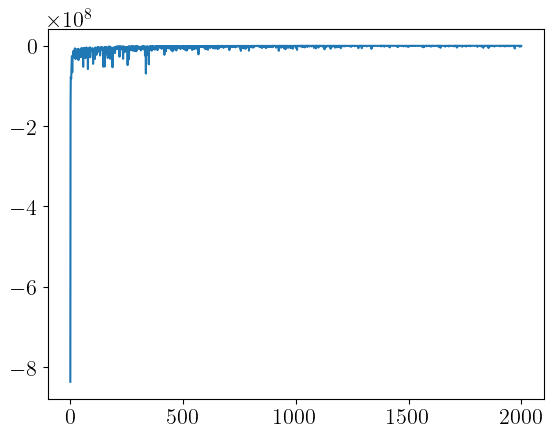

0.0


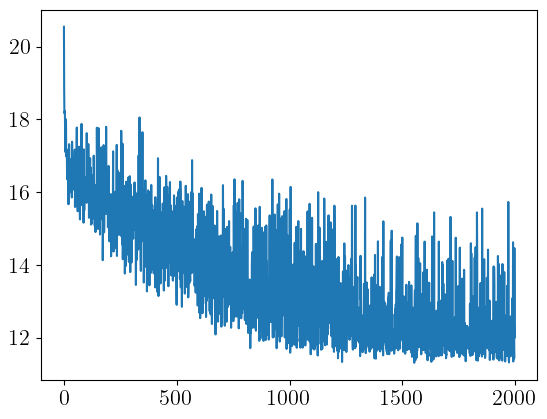

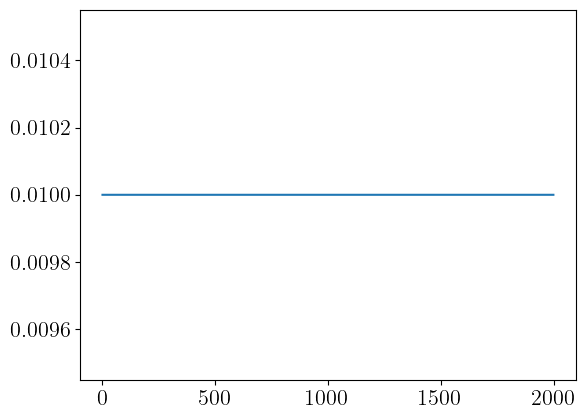

totalTimeTrainingPDLVM = 297.56m


In [9]:
ebloAll = tf.stack(elboAll)
LOSS    = np.array(ebloAll)
plt.plot(range(LOSS.shape[0]), LOSS )
plt.show()
print(np.isnan(LOSS).mean())
plt.plot(range(LOSS.shape[0]), np.log(-LOSS) )
plt.show()
stack_epsAll = tf.stack(epsAll)
plt.plot(range( len(epsAll)), stack_epsAll )
plt.show()

np.savetxt(dirname  + 'ebloAll.dat' , ebloAll )
np.savetxt(dirname  + 'epsAll.dat'  , stack_epsAll )
print('totalTimeTrainingPDLVM = {:.2f}m'.format( totalTimeTrainingPDLVM ) )


plotting
x.shape (100000, 3)
x_input.shape (100000, 203)
alpha mean.shape =  (100000, 3)
alpha logvar.shape =  (100000, 3)


/home/av537@ad.eng.cam.ac.uk/miniconda3/envs/lfm/lib/python3.10/site-packages/matplotlib/patches.py:3389: RuntimeWarning: invalid value encountered in double_scalars
  cos_t, sin_t = head_length / head_dist, head_width / head_dist


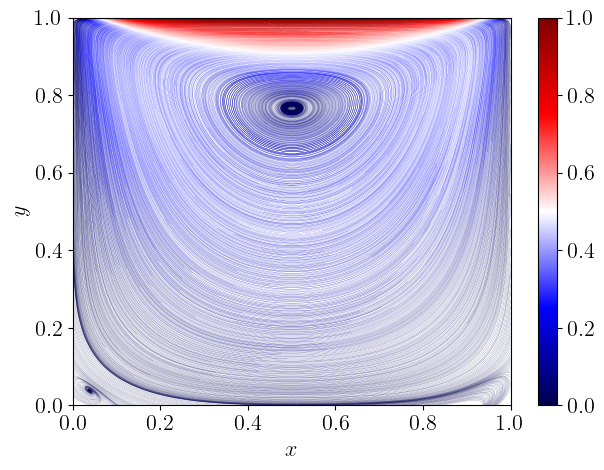

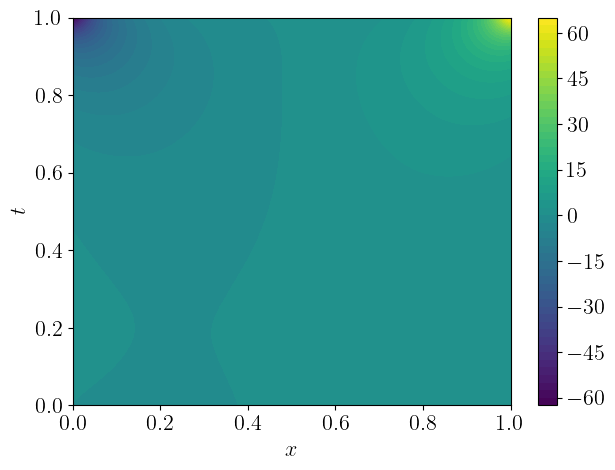

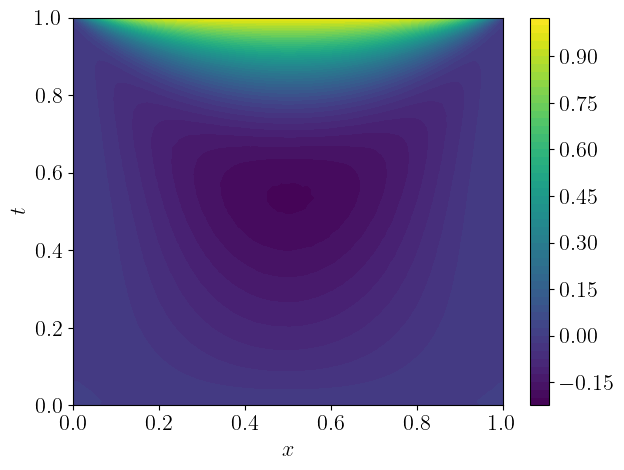

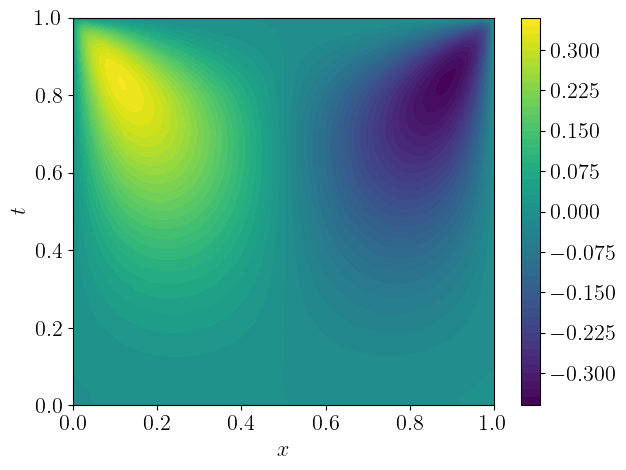

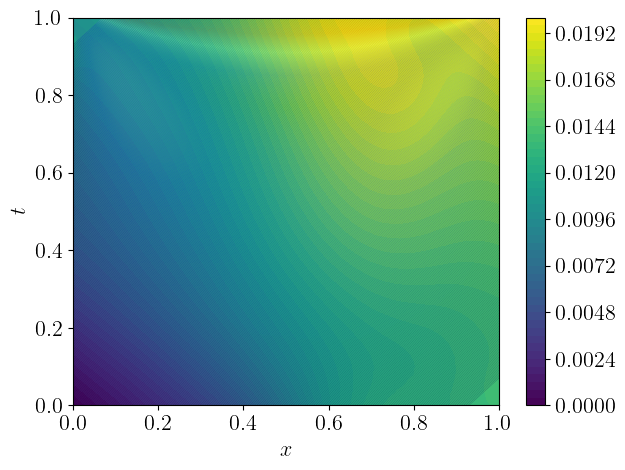

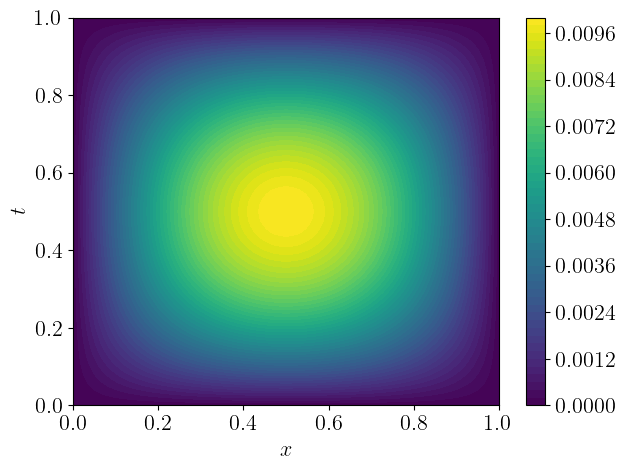

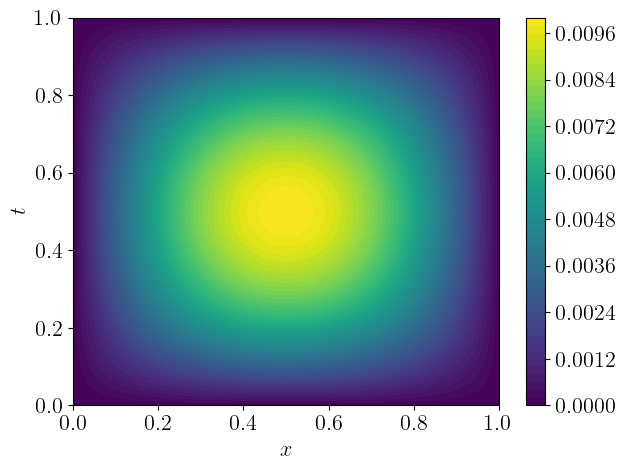

mapped.shape =  (1, 4)
beta mean.shape =  (1, 2)
beta logvar.shape =  (1, 2)
mean_beta =  tf.Tensor([[0.9008926  0.99263763]], shape=(1, 2), dtype=float32)
std_beta =  tf.Tensor([[0.05817471 0.01      ]], shape=(1, 2), dtype=float32)


In [10]:
z = [1., 1.]
w = [1.]
print('plotting')
resoTEST = [100, 100, 10]
pt = 9
X, Y, T = np.meshgrid( tf.linspace(0., 1., resoTEST[0]), tf.linspace(0., 1., resoTEST[1]), tf.linspace(0., 1., resoTEST[2]), indexing='xy')

xr, yr, tr = tf.reshape(X, [-1,1]), tf.reshape(Y, [-1,1]), tf.reshape(T, [-1,1])

mean_alpha, logvar_alpha = alphaNet( z, w, tf.concat([xr, yr, tr], 1) )

mean_alpha_stack   = tf.reshape(mean_alpha,   [-1,1])
logvar_alpha_stack = tf.reshape(logvar_alpha, [-1,1])

# uvp_untrans = tf.reshape(reparameterize(mean_alpha_stack, logvar_alpha_stack), [-1, dimU])
uvp_untrans = mean_alpha


u_untrans, v_untrans, p_untrans          = uvp_untrans[:, 0:1], uvp_untrans[:, 1:2], uvp_untrans[:, 2:3]
u_untrans_lv, v_untrans_lv, p_untrans_lv = logvar_alpha[:, 0:1], logvar_alpha[:, 1:2], logvar_alpha[:, 2:3]

u_vec = base_u(xr, yr, tr, w) + D_square(xr, yr, tr) * u_untrans
v_vec =                         D_square(xr, yr, tr) * v_untrans
p_vec =                         D_p(xr, yr, tr)      * p_untrans

P_vec = tf.reshape(p_vec, resoTEST)
U_vec = tf.reshape(u_vec, resoTEST)
V_vec = tf.reshape(v_vec, resoTEST)


u_vec_std =  tf.sqrt( D_square(xr, yr, tr)**2. * tf.exp( u_untrans_lv ) )
v_vec_std =  tf.sqrt( D_square(xr, yr, tr)**2. * tf.exp( v_untrans_lv ) )
p_vec_std =  tf.sqrt( D_p(xr, yr, tr)     **2. * tf.exp( p_untrans_lv ) )

P_vec_std = tf.reshape(p_vec_std, resoTEST)
U_vec_std = tf.reshape(u_vec_std, resoTEST)
V_vec_std = tf.reshape(v_vec_std, resoTEST)


fig, ax = plt.subplots()

########### plot slns ###########
mag_vec = np.array( tf.linalg.norm(tf.concat([U_vec[...,pt:pt+1], V_vec[...,pt:pt+1]],-1), axis=-1))

strm  = ax.streamplot(X[...,pt], Y[...,pt], U_vec[...,pt], V_vec[...,pt], color=mag_vec, density=8,cmap = plt.cm.seismic,
                        broken_streamlines=False, linewidth=0.1, arrowsize=0.)  
# strm  = ax.quiver(X, Y,U_vec, V_vec)
# ax.contourf(X,Y, P_vec, 50)
fig.colorbar(strm.lines, ax=ax)
ax.set(xlabel=r'$x$', ylabel=r'$y$')
ax.set_xlim(0., 1.)
ax.set_ylim(0., 1.)
plt.tight_layout()
plt.savefig(dirname + 'strlines.png', dpi=300)
plt.show()

plt.contourf(X[...,pt],Y[...,pt], P_vec[...,pt], 50)
plt.colorbar()
plt.xlim(0., 1.)
plt.ylim(0., 1.)
plt.ylabel(r'$t$')
plt.xlabel(r'$x$')
plt.tight_layout()
plt.savefig(dirname + 'P.png', dpi=300)
plt.show()
plt.close()

plt.contourf(X[...,pt],Y[...,pt], U_vec[...,pt], 50)
plt.colorbar()
plt.xlim(0., 1.)
plt.ylim(0., 1.)
plt.ylabel(r'$t$')
plt.xlabel(r'$x$')
plt.tight_layout()
plt.savefig(dirname + 'U.png', dpi=300)
plt.show()
plt.close()


plt.contourf(X[...,pt],Y[...,pt], V_vec[...,pt], 50)
plt.colorbar()
plt.xlim(0., 1.)
plt.ylim(0., 1.)
plt.ylabel(r'$t$')
plt.xlabel(r'$x$')
plt.tight_layout()
plt.savefig(dirname + 'V.png', dpi=300)
plt.show()
plt.close()

########### plot stddev ###########
fig, ax = plt.subplots()

mag_vec_std = np.array( tf.linalg.norm(tf.concat([U_vec_std[...,pt:pt+1], V_vec_std[...,pt:pt+1]],-1), axis=-1))

strm  = ax.streamplot(X[...,pt], Y[...,pt], U_vec_std[...,pt], V_vec_std[...,pt], color=mag_vec, density=8,cmap = plt.cm.seismic,
                        broken_streamlines=False, linewidth=0.1, arrowsize=0.)  
# strm  = ax.quiver(X, Y,U_vec, V_vec)
# ax.contourf(X,Y, P_vec, 50)
# fig.colorbar(strm.lines, ax=ax)
# ax.set(xlabel=r'$x$', ylabel=r'$y$')
# ax.set_xlim(0., 1.)
# ax.set_ylim(0., 1.)
# plt.ylabel(r'$t$')
# plt.xlabel(r'$x$')
# plt.tight_layout()
# plt.savefig(dirname + 'strlines_std.png', dpi=300)
# plt.show()

plt.contourf(X[...,pt],Y[...,pt], P_vec_std[...,pt], 50)
plt.colorbar()
plt.xlim(0., 1.)
plt.ylim(0., 1.)
plt.ylabel(r'$t$')
plt.xlabel(r'$x$')
plt.tight_layout()
plt.savefig(dirname + 'Pressure_std.png', dpi=300)
plt.show()
plt.close()

plt.contourf(X[...,pt],Y[...,pt], U_vec_std[...,pt], 50)
plt.colorbar()
plt.xlim(0., 1.)
plt.ylim(0., 1.)
plt.ylabel(r'$t$')
plt.xlabel(r'$x$')
plt.tight_layout()
plt.savefig(dirname + 'U_std.png', dpi=300)
plt.show()
plt.close()


plt.contourf(X[...,pt],Y[...,pt], V_vec_std[...,pt], 50)
plt.colorbar()
plt.xlim(0., 1.)
plt.ylim(0., 1.)
plt.ylabel(r'$t$')
plt.xlabel(r'$x$')
plt.tight_layout()
plt.savefig(dirname + 'V_std.png', dpi=300)
plt.show()
plt.close()

mean_beta, logvar_beta = betaNet( tf.reshape(uvp_untrans, [-1,dimU]), w[0], tf.concat([xr, yr, tr], 1) ) 

print('mean_beta = ', mean_beta)
print('std_beta = ', tf.exp(logvar_beta * 0.5) )


P_vec_all.shape (100, 48, 48, 49)
U_vec_all.shape (100, 48, 48, 49)
V_vec_all.shape (100, 48, 48, 49)
allZ     .shape (100, 2)
allW     .shape (100,)
fenics_XY.shape (2, 48, 48)
fenics_T .shape (49,)
fenicsXYT.shape (3, 48, 48, 49)
pt =  48


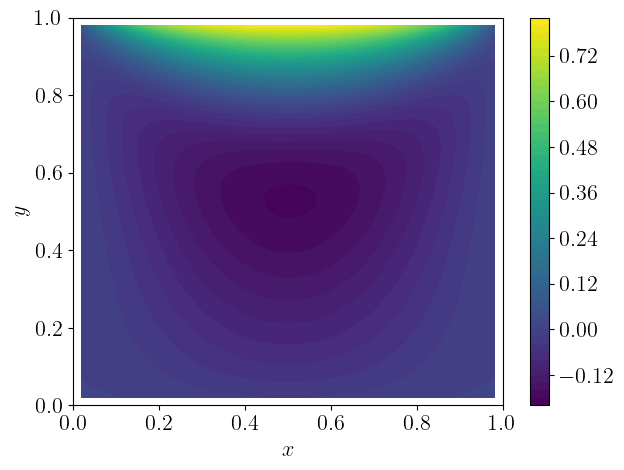

zTrue =  tf.Tensor(
[[0.95391154]
 [0.3662704 ]], shape=(2, 1), dtype=float32)
wTrue =  tf.Tensor(1.0, shape=(), dtype=float32)
x.shape (112896, 3)
x_input.shape (112896, 203)
alpha mean.shape =  (112896, 3)
alpha logvar.shape =  (112896, 3)
mapped.shape =  (1, 4)
beta mean.shape =  (1, 2)
beta logvar.shape =  (1, 2)
zTrue =  tf.Tensor(
[[0.84546167]
 [0.59973586]], shape=(2, 1), dtype=float32)
wTrue =  tf.Tensor(1.0, shape=(), dtype=float32)
x.shape (112896, 3)
x_input.shape (112896, 203)
alpha mean.shape =  (112896, 3)
alpha logvar.shape =  (112896, 3)
mapped.shape =  (1, 4)
beta mean.shape =  (1, 2)
beta logvar.shape =  (1, 2)
zTrue =  tf.Tensor(
[[0.86780584]
 [0.33916065]], shape=(2, 1), dtype=float32)
wTrue =  tf.Tensor(1.0, shape=(), dtype=float32)
x.shape (112896, 3)
x_input.shape (112896, 203)
alpha mean.shape =  (112896, 3)
alpha logvar.shape =  (112896, 3)
mapped.shape =  (1, 4)
beta mean.shape =  (1, 2)
beta logvar.shape =  (1, 2)
zTrue =  tf.Tensor(
[[0.97559106]
 [0.99127

mapped.shape =  (1, 4)
beta mean.shape =  (1, 2)
beta logvar.shape =  (1, 2)
zTrue =  tf.Tensor(
[[0.90590525]
 [0.86048275]], shape=(2, 1), dtype=float32)
wTrue =  tf.Tensor(1.0, shape=(), dtype=float32)
x.shape (112896, 3)
x_input.shape (112896, 203)
alpha mean.shape =  (112896, 3)
alpha logvar.shape =  (112896, 3)
mapped.shape =  (1, 4)
beta mean.shape =  (1, 2)
beta logvar.shape =  (1, 2)
zTrue =  tf.Tensor(
[[0.9144833]
 [0.9280577]], shape=(2, 1), dtype=float32)
wTrue =  tf.Tensor(1.0, shape=(), dtype=float32)
x.shape (112896, 3)
x_input.shape (112896, 203)
alpha mean.shape =  (112896, 3)
alpha logvar.shape =  (112896, 3)
mapped.shape =  (1, 4)
beta mean.shape =  (1, 2)
beta logvar.shape =  (1, 2)
zTrue =  tf.Tensor(
[[0.8116625 ]
 [0.46856824]], shape=(2, 1), dtype=float32)
wTrue =  tf.Tensor(1.0, shape=(), dtype=float32)
x.shape (112896, 3)
x_input.shape (112896, 203)
alpha mean.shape =  (112896, 3)
alpha logvar.shape =  (112896, 3)
mapped.shape =  (1, 4)
beta mean.shape =  (1,

mapped.shape =  (1, 4)
beta mean.shape =  (1, 2)
beta logvar.shape =  (1, 2)
zTrue =  tf.Tensor(
[[0.8224289]
 [0.2926756]], shape=(2, 1), dtype=float32)
wTrue =  tf.Tensor(1.0, shape=(), dtype=float32)
x.shape (112896, 3)
x_input.shape (112896, 203)
alpha mean.shape =  (112896, 3)
alpha logvar.shape =  (112896, 3)
mapped.shape =  (1, 4)
beta mean.shape =  (1, 2)
beta logvar.shape =  (1, 2)
zTrue =  tf.Tensor(
[[0.9103065 ]
 [0.17670023]], shape=(2, 1), dtype=float32)
wTrue =  tf.Tensor(1.0, shape=(), dtype=float32)
x.shape (112896, 3)
x_input.shape (112896, 203)
alpha mean.shape =  (112896, 3)
alpha logvar.shape =  (112896, 3)
mapped.shape =  (1, 4)
beta mean.shape =  (1, 2)
beta logvar.shape =  (1, 2)
zTrue =  tf.Tensor(
[[0.9412642]
 [0.9446026]], shape=(2, 1), dtype=float32)
wTrue =  tf.Tensor(1.0, shape=(), dtype=float32)
x.shape (112896, 3)
x_input.shape (112896, 203)
alpha mean.shape =  (112896, 3)
alpha logvar.shape =  (112896, 3)
mapped.shape =  (1, 4)
beta mean.shape =  (1, 2

mapped.shape =  (1, 4)
beta mean.shape =  (1, 2)
beta logvar.shape =  (1, 2)
zTrue =  tf.Tensor(
[[0.8496812]
 [0.2398906]], shape=(2, 1), dtype=float32)
wTrue =  tf.Tensor(1.0, shape=(), dtype=float32)
x.shape (112896, 3)
x_input.shape (112896, 203)
alpha mean.shape =  (112896, 3)
alpha logvar.shape =  (112896, 3)
mapped.shape =  (1, 4)
beta mean.shape =  (1, 2)
beta logvar.shape =  (1, 2)
zTrue =  tf.Tensor(
[[0.8584274 ]
 [0.79234004]], shape=(2, 1), dtype=float32)
wTrue =  tf.Tensor(1.0, shape=(), dtype=float32)
x.shape (112896, 3)
x_input.shape (112896, 203)
alpha mean.shape =  (112896, 3)
alpha logvar.shape =  (112896, 3)
mapped.shape =  (1, 4)
beta mean.shape =  (1, 2)
beta logvar.shape =  (1, 2)
zTrue =  tf.Tensor(
[[0.8746551]
 [0.1483391]], shape=(2, 1), dtype=float32)
wTrue =  tf.Tensor(1.0, shape=(), dtype=float32)
x.shape (112896, 3)
x_input.shape (112896, 203)
alpha mean.shape =  (112896, 3)
alpha logvar.shape =  (112896, 3)
mapped.shape =  (1, 4)
beta mean.shape =  (1, 2

RuntimeError: No active exception to reraise

In [12]:
# dirnameGT = '../../../fenics/NSLid/data-groundTruth-nslid_10'
# dirnameGT = '../../../fenics/NSLid/data-groundTruth-nslid_100'
dirnameGT = '../../../fenics/NSLid/data-groundTruth-nslid_100_0_8-1--0_1-1--1-1'

# saved i, T, X, Y
# want  i, X, Y, T
P_vec_all = tf.constant( np.load(dirnameGT+'/'+'SolutionsPGT.npy'), dtype=tf.float32)
U_vec_all = tf.constant( np.load(dirnameGT+'/'+'SolutionsUGT.npy'), dtype=tf.float32)
V_vec_all = tf.constant( np.load(dirnameGT+'/'+'SolutionsVGT.npy'), dtype=tf.float32)

pad       = 1
padt      = 1
P_vec_all = tf.transpose(P_vec_all, [0, 2, 3, 1])[:, pad:-pad, pad:-pad, padt:]
U_vec_all = tf.transpose(U_vec_all, [0, 2, 3, 1])[:, pad:-pad, pad:-pad, padt:]
V_vec_all = tf.transpose(V_vec_all, [0, 2, 3, 1])[:, pad:-pad, pad:-pad, padt:]

allZ      = tf.constant( np.loadtxt(dirnameGT+'/'+'allZ.dat' )    , dtype=tf.float32)
allW      = tf.constant( np.loadtxt(dirnameGT+'/'+ 'allW.dat')    , dtype=tf.float32)
fenics_XY = tf.constant( np.load(dirnameGT+'/'+'FenicsMeshXY.npy'), dtype=tf.float32)[:, pad:-pad, pad:-pad]
fenics_T  = tf.constant( np.load(dirnameGT+'/'+'FenicsMeshT.npy') , dtype=tf.float32)[padt:]


print('P_vec_all.shape', P_vec_all.shape)
print('U_vec_all.shape', U_vec_all.shape)
print('V_vec_all.shape', V_vec_all.shape)

print('allZ     .shape', allZ     .shape)
print('allW     .shape', allW     .shape)
print('fenics_XY.shape', fenics_XY.shape)
print('fenics_T .shape', fenics_T .shape)

nx = fenics_XY.shape[1]
nt = fenics_XY.shape[2]

saveDataList = True

if saveDataList:

     allresAbsMean = []

     allSampleZs   = []
     allMeanZs     = []
     allStdZs      = []

     allUSamples = []
     allUMeans   = []
     allUStd     = []
        
     allVSamples = []
     allVMeans   = []
     allVStd     = []

     allZNSE       = []
     allUNSE       = []
     allVNSE       = []


     Pin2SigK = []
     Pin2SigU = []
     Pin2SigV = []

# XYT 3, 50,50,20
# XY  2, 50, 50
# T   20
fenics_XYtile = tf.tile(fenics_XY[..., None], [1,1,1,fenics_T.shape[0]])
fenics_Ttile  = tf.tile(fenics_T[None, None, None, :], [1, fenics_XY.shape[1], fenics_XY.shape[2], 1])
fenics_XYT    = tf.concat([fenics_XYtile, fenics_Ttile], 0)
print('fenicsXYT.shape', fenics_XYT.shape)

pt    = fenics_XYT.shape[3]-1
print('pt = ', pt)
plt.contourf(fenics_XYT[0,...,pt], fenics_XYT[1,...,pt], U_vec_all[0,...,pt], 50)
plt.colorbar( )
plt.xlim(0., 1.)
plt.ylim(0., 1.)
plt.ylabel(r'$y$')
plt.xlabel(r'$x$')
plt.tight_layout()
plt.show()
plt.close()

# Xtest, Ytest  = fenics_XY[0], fenics_XY[1]

# xtest, ytest = tf.reshape(Xtest, [-1,1]), tf.reshape(Ytest, [-1,1])

# xyttest_rav  = tf.reshape(fenics_XYT, [-1, dimX])
xr, yr, tr   = tf.reshape(fenics_XYT[0], [-1,1]), tf.reshape(fenics_XYT[1], [-1,1]), tf.reshape(fenics_XYT[2], [-1,1])
xyttest_rav  = tf.concat([xr, yr, tr], 1)
# XYT  = tf.reshape(xytr, fenics_XYT.shape)
# print('arrays the same = ', np.array_equal(XYT, fenics_XYT, equal_nan=False))

# tf_residualFunction = tf.function( residualFunction )#residualFunction #
# tf_alphaNet         = tf.function( alphaNet         )#alphaNet         #
# tf_betaNet          = tf.function( betaNet          )#betaNet          #
tf_residualFunction = residualFunction #
tf_alphaNet         = alphaNet         #
tf_betaNet          = betaNet          #


PLOT        = False
savePlots   = False
BenchParams = False
writeToFile = False

for i in range(U_vec_all.shape[0]):
# for i in range(20):
# for i in [5]:


     zTrue = tf.reshape( allZ[i], [-1, 1] )
     wTrue = tf.reshape( allW[i], [ ] )
     uTrue = tf.reshape( U_vec_all[i], [-1, 1] )
     vTrue = tf.reshape( V_vec_all[i], [-1, 1] )
     pTrue = tf.reshape( P_vec_all[i], [-1, 1] )

    
     if BenchParams:
          zTrue = tf.constant([1., 0.1])
          wTrue = tf.constant([1.])

     print('zTrue = ', zTrue)
     print('wTrue = ', wTrue)
     
     mean_alpha, logvar_alpha = tf_alphaNet( zTrue, wTrue, xyttest_rav )
     mean_alpha_stack   = tf.reshape(mean_alpha,   [-1,1])
     logvar_alpha_stack = tf.reshape(logvar_alpha, [-1,1])
 
#      uvp_untrans = tf.reshape(reparameterize(mean_alpha_stack, logvar_alpha_stack), [-1, dimU])
     uvp_untrans = mean_alpha
     u_untrans, v_untrans, p_untrans = uvp_untrans[:, 0:1], uvp_untrans[:, 1:2], uvp_untrans[:, 2:3]

     u_vec = base_u(xr, yr, tr, wTrue) + D_square(xr, yr, tr) * u_untrans
     v_vec =                             D_square(xr, yr, tr) * v_untrans
     p_vec =                             D_p(xr, yr, tr)      * p_untrans

     if PLOT == True:
          U_vec = tf.reshape(u_vec, fenics_XYT[0].shape)
          # plt.tricontourf(xr[:,0], yr[:,0], u_vec[:,0], 50)
          # plt.tricontourf(xr[:,0], yr[:,0], uTrue[:,0], 50)
          plt.contourf(fenics_XYT[0,...,pt],fenics_XYT[1,...,pt], U_vec[...,pt], 50)
          plt.colorbar()
          plt.xlim(0., 1.)
          plt.ylim(0., 1.)
          plt.ylabel(r'$t$')
          plt.xlabel(r'$x$')
          plt.tight_layout()
          plt.show()
          plt.close()

          UTrue = tf.reshape(uTrue, fenics_XYT[0].shape)
          # plt.tricontourf(xr[:,0], yr[:,0], u_vec[:,0], 50)
          # plt.tricontourf(xr[:,0], yr[:,0], uTrue[:,0], 50)
          plt.contourf(fenics_XYT[0,...,pt],fenics_XYT[1,...,pt], UTrue[...,pt], 50)
          plt.colorbar()
          plt.xlim(0., 1.)
          plt.ylim(0., 1.)
          plt.ylabel(r'$t$')
          plt.xlabel(r'$x$')
          plt.tight_layout()
          plt.show()
          plt.close()

          V_vec = tf.reshape(v_vec, fenics_XYT[0].shape)
          # plt.tricontourf(xr[:,0], yr[:,0], u_vec[:,0], 50)
          # plt.tricontourf(xr[:,0], yr[:,0], uTrue[:,0], 50)
          plt.contourf(fenics_XYT[0,...,pt],fenics_XYT[1,...,pt], V_vec[...,pt], 50)
          plt.colorbar()
          plt.xlim(0., 1.)
          plt.ylim(0., 1.)
          plt.ylabel(r'$t$')
          plt.xlabel(r'$x$')
          plt.tight_layout()
          plt.show()
          plt.close()

          VTrue = tf.reshape(vTrue, fenics_XYT[0].shape)
          # plt.tricontourf(xr[:,0], yr[:,0], u_vec[:,0], 50)
          # plt.tricontourf(xr[:,0], yr[:,0], uTrue[:,0], 50)
          plt.contourf(fenics_XYT[0,...,pt],fenics_XYT[1,...,pt], VTrue[...,pt], 50)
          plt.colorbar()
          plt.xlim(0., 1.)
          plt.ylim(0., 1.)
          plt.ylabel(r'$t$')
          plt.xlabel(r'$x$')
          plt.tight_layout()
          plt.show()
          plt.close()

     u_untrans_lv, v_untrans_lv, p_untrans_lv = logvar_alpha[:, 0:1], logvar_alpha[:, 1:2], logvar_alpha[:, 2:3]

     u_vec_std = tf.sqrt( D_square(xr, yr, tr) ** 2. * tf.exp( u_untrans_lv ) )
     v_vec_std = tf.sqrt( D_square(xr, yr, tr) ** 2. * tf.exp( v_untrans_lv ) )
     p_vec_std = tf.sqrt( D_p(xr, yr, tr)      ** 2. * tf.exp( p_untrans_lv ) )
     
     p_true_unstranf        = (pTrue ) / ( D_p(xr, yr, tr) )
     u_true_unstranf        = (uTrue - base_u(xr, yr, tr, wTrue)) / ( D_square(xr, yr, tr) )
     v_true_unstranf        = (vTrue ) / ( D_square(xr, yr, tr) )
     uvp_true_untransf      = tf.concat([u_true_unstranf, v_true_unstranf, p_true_unstranf], 1)
     tf.debugging.assert_all_finite(uvp_true_untransf, 'uvp_untrsanf not finite')
     mean_beta, logvar_beta = tf_betaNet( uvp_true_untransf, wTrue,  xyttest_rav )

     mean_beta, logvar_beta = tf.squeeze( mean_beta), tf.squeeze( logvar_beta )
     sampleZ  = reparameterize( mean_beta, logvar_beta )
     std_beta = tf.exp( 0.5 * logvar_beta)

     if saveDataList:

          allSampleZs.append(tf.squeeze(sampleZ))
          allMeanZs.append(tf.squeeze(mean_beta))
          allStdZs.append(std_beta)

          allUSamples.append(tf.squeeze(u_vec))
          allVSamples.append(tf.squeeze(v_vec))
        
          allUStd.append(tf.squeeze(u_vec_std))
          allVStd.append(tf.squeeze(v_vec_std))
          
          allZNSE.append( ( tf.linalg.norm((tf.squeeze(mean_beta) - tf.squeeze(zTrue)) ) / tf.linalg.norm(tf.squeeze(zTrue)) )**2. )

          allUNSE.append( ( tf.linalg.norm((tf.squeeze(u_vec) - tf.squeeze(uTrue)) ) / tf.linalg.norm(tf.squeeze(uTrue)) )**2. )
          allVNSE.append( ( tf.linalg.norm((tf.squeeze(v_vec) - tf.squeeze(vTrue)) ) / tf.linalg.norm(tf.squeeze(vTrue)) )**2. )

          Pin2SigK.append( tf.reduce_sum(tf.where(tf.math.logical_and( 
               tf.squeeze(zTrue) >  tf.squeeze(mean_beta-2*std_beta), tf.squeeze(zTrue) <  tf.squeeze(mean_beta+2*std_beta)
               ), 1, 0)) /  tf.squeeze(zTrue).shape[0] )

          Pin2SigU.append( tf.reduce_sum(tf.where(tf.math.logical_and(
               tf.squeeze(uTrue) > tf.squeeze(u_vec-2*u_vec_std), tf.squeeze(uTrue) < tf.squeeze(u_vec+2*u_vec_std)
               ), 1, 0)) / tf.squeeze(uTrue).shape[0]  )
        
          Pin2SigV.append( tf.reduce_sum(tf.where(tf.math.logical_and(
               tf.squeeze(vTrue) > tf.squeeze(v_vec-2*v_vec_std), tf.squeeze(vTrue) < tf.squeeze(v_vec+2*v_vec_std)
               ), 1, 0)) / tf.squeeze(vTrue).shape[0]  )


print('mean allZNSE = ', tf.reduce_mean( tf.stack(allZNSE) ) )
print('mean allUNSE = ', tf.reduce_mean( tf.stack(allUNSE) ) )
print('mean allVNSE = ', tf.reduce_mean( tf.stack(allVNSE) ) )

print('sttdev allZNSE = ', tf.math.reduce_std( tf.stack(allZNSE) ) )
print('sttdev allUNSE = ', tf.math.reduce_std( tf.stack(allUNSE) ) )
print('sttdev allVNSE = ', tf.math.reduce_std( tf.stack(allVNSE) ) )


# print('median allZNSE = ', tfp.stats.percentile( allZNSE, 50 ) )

print('Pin2SigK = ', tf.reduce_mean(tf.stack(Pin2SigK)))
print('Pin2SigU = ', tf.reduce_mean(tf.stack(Pin2SigU)))
print('Pin2SigV = ', tf.reduce_mean(tf.stack(Pin2SigV)))

# print('allUStd = ', tf.reduce_mean(tf.stack(allUStd)))

if writeToFile:
     with  open(dirname+"allInfoRun.txt", "w") as f:
          f.write('mean allZNSE = {}\n'.format(tf.reduce_mean( tf.stack(allZNSE) )) )
          f.write('mean allUNSE = {}\n'.format(tf.reduce_mean( tf.stack(allUNSE) )) )
          f.write('mean allVNSE = {}\n'.format(tf.reduce_mean( tf.stack(allVNSE) )) )
          f.write('sttdev allZNSE = {}\n'.format(tf.math.reduce_std( tf.stack(allZNSE) )) )
          f.write('sttdev allUNSE = {}\n'.format(tf.math.reduce_std( tf.stack(allUNSE) )) )
          f.write('sttdev allVNSE = {}\n'.format(tf.math.reduce_std( tf.stack(allVNSE) )) )
          f.write('Pin2SigK = {}\n'.format(tf.reduce_mean(tf.stack(Pin2SigK))) )
          f.write('Pin2SigU = {}\n'.format(tf.reduce_mean(tf.stack(Pin2SigU))) )
          f.write('Pin2SigV = {}\n'.format(tf.reduce_mean(tf.stack(Pin2SigV))) )
          f.write('totalTimeTrainingPDLVM = {:.2f}m\n'.format( totalTimeTrainingPDLVM ))
     f.close()

print('totalTimeTrainingPDLVM = {:.2f}m'.format( totalTimeTrainingPDLVM ) )



raise

In [ ]:
saveData = True
if saveData:

    allSampleZs_np = tf.stack(allSampleZs)
    allMeanZs_np   = tf.stack(allMeanZs)
    allStdZs_np    = tf.stack(allStdZs)

    allUSamples_np  = tf.stack(allUSamples)
    allUMeans_np    = tf.stack(allUMeans)
    allUStd_np      = tf.stack(allUStd)

    prefix = 'randgrid{}_{}kIter'.format(nxSamples, int(num_iterations/1000))

    np.savetxt(dirname + prefix + '_allRes_np.dat'   , tf.stack(tf.squeeze(allresAbsMean)) )


    np.savetxt(dirname + prefix + '_allSampleZs_np.dat', allSampleZs_np)
    np.savetxt(dirname + prefix + '_allMeanZs_np.dat'  , allMeanZs_np)
    np.savetxt(dirname + prefix + '_allStdZs_np.dat'  , allMeanZs_np)


    np.savetxt(dirname + prefix + '_allUSamples_np.dat' , allUSamples_np)
    np.savetxt(dirname + prefix + '_allUMeans_np.dat'   , allUMeans_np)
    np.savetxt(dirname + prefix + '_allUStd_np.dat'     , allUStd_np)
    
    np.savetxt(dirname + prefix + '_allZNSE_np.dat'   , tf.stack( allZNSE ) )
    np.savetxt(dirname + prefix + '_allUNSE_np.dat'   , tf.stack( allUNSE ) )

In [ ]:
for layer in betaNet.NN.kipLayers:
    print(layer.ell)